In [40]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

%matplotlib inline
%matplotlib notebook
mypath = "C:/Users/Huayi/Desktop/DataChallenges/BreastCancerDetection/"

## Part 1: A logistic regression model

### 1.1 Assign training & testing data

In [41]:
# read in the cleaned data
df = pd.read_csv(mypath+'Data/cleaned_df.csv', index_col = [0])

In [42]:
# to deal with unbalanced data, try upsampling
from sklearn.utils import resample

# Separate majority and minority classes
df_mj = df[df.Class==0] # benign
df_mi = df[df.Class==1] # malignant
 
# Upsample minority class, with replacement 
df_mi_up = resample(df_mi, replace=True, n_samples=len(df_mj), random_state=101) 
 
# Combine majority class with upsampled minority class
df_up= pd.concat([df_mj, df_mi_up])
 
# Display new class counts
df_up.Class.value_counts()

1.0    15313
0.0    15313
Name: Class, dtype: int64

In [43]:
df_up.head(3)

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
Index,,,,,,,,,,,
0,1241035.0,7.0,8.0,3.0,7.0,4.0,5.0,7.0,8.0,2.0,0.0
1,1107684.0,6.0,10.0,5.0,5.0,4.0,10.0,6.0,10.0,1.0,0.0
2,691628.0,8.0,6.0,4.0,10.0,10.0,1.0,3.0,5.0,1.0,0.0


In [354]:
from sklearn.model_selection import train_test_split
X = df_up.values[:,1:-1]
y = df_up.Class.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### 1.2 Train the model

In [324]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf_1 = LogisticRegression().fit(X_train, y_train)
pred_y_1 = clf_1.predict(X_test)
print(classification_report(y_test,pred_y_1))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      4557
         1.0       1.00      0.99      0.99      4631

    accuracy                           0.99      9188
   macro avg       0.99      0.99      0.99      9188
weighted avg       0.99      0.99      0.99      9188



In [447]:
import joblib

# save model to disk
joblib.dump(clf_1, mypath + 'Model/clf_1.sav')

['C:/Users/Huayi/Desktop/DataChallenges/BreastCancerDetection/Model/clf_1.sav']

### 1.3 Evaluate the model

In [394]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,pred_y_1)
print(cm)

[[4549    8]
 [  43 4588]]


In [406]:
FPR = cm[0][1]/sum(cm[0])
FNR = cm[1][0]/sum(cm[1])
print('The False Positive Rate is %.3f' %(FPR))
print('The False Negative Rate is %.3f' %(FNR))

The False Positive Rate is 0.002
The False Negative Rate is 0.009


In [327]:
# check the ROC curve to see where the model is at. 
from sklearn.metrics import roc_auc_score, roc_curve

def roc_auc(model,model_name, X_test, y_test):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(model_name+': ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.figure()
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(); plt.show()

No Skill: ROC AUC=0.500
clf_1: ROC AUC=0.999


<IPython.core.display.Javascript object>


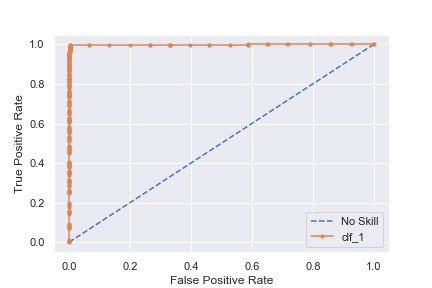

In [430]:
roc_auc(clf_1,'clf_1', X_test, y_test)

## Model 1 evaluation
- The model performed reasonably well as FPR & FNR are low (0.002 & 0.009 respectively) and AUC is 0.999. 
- However, as the cost of having FN is probably higher than having FP, the model can be tweaked in the future to further minimize FN. It would also be good to know what's the clinically acceptable FNR and FPR.

## Part 2: Understanding factors in the Logistic Regression Model that predicts malignancy, false positive rate, false negative rate

### 2.1 Find factors are predicts malignancy by using 3 different methods

#### Method 1 for determining which factor is the most important: by coefficient value



In [329]:
features = df.columns[1:-1]
# positive coefficient of the model positively correlates with malignancy 
print("Top feautures predicted by Method#1 are: " + ', '.join(features[clf_1.coef_[0]>0]))

Top feautures predicted by Method#1 are: Single Epithelial Cell Size, Normal Nucleoli


#### Method 2: RFE

 RFE = recursive feature elimination: select features by recursively considering smaller and smaller sets of features

In [330]:
from sklearn.feature_selection import RFE
selector = RFE(clf_1, 2) # find top 2 features as Method 1 found 2 features.
selector = selector.fit(X_train, y_train)
order = selector.ranking_
order

array([1, 2, 6, 1, 5, 7, 4, 8, 3])

In [331]:
print("Top feautures predicted by Method#2 are: " + ', '.join(features[order ==1]))
# interestingly, this method gives us a very different result

Top feautures predicted by Method#2 are: Clump Thickness, Marginal Adhesion


#### Method3: SelectFromModel

selecting features based on importance weights.

In [332]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(clf_1, max_features =2).fit(X_train, y_train)
print("Top feautures predicted by Method#3 are: " + ', '.join(features[sfm.get_support()]))
# this method gives a result that's different from previous two. 

Top feautures predicted by Method#3 are: Uniformity of Cell Size, Mitoses


#### Evaluate which method gives the best results

In [386]:
def FeaturePos(ft_subset, features):
    '''
    Find positions of features in the list of features
    '''
    pos = []
    for i in ft_subset:
        pos.append(np.where(features == i)[0][0])
    return(pos)

In [387]:
def GenXTest(pos, X_test):
    '''
    Generate X_test where features not listed in pos are set to 0. 
    '''
    X_test_m1 = np.zeros(np.shape(X_test))
    for i in range(len(X_test_m1)):
         X_test_m1[i][pos] = X_test[i][pos]
    return(X_test_m1)

In [390]:
def MethodAuc(X_test_m1,m1_subset,MethodN, y_test): 
    m1_probs = clf_1.predict_proba(X_test_m1)
    m1_auc = roc_auc_score(y_test, m1_probs[:,1])
    print('Method '+str(MethodN) +': ROC AUC=%.3f' % (m1_auc))

In [391]:
m1_subset = ['Single Epithelial Cell Size','Normal Nucleoli']
m2_subset = ['Clump Thickness', 'Marginal Adhesion']
m3_subset = ['Uniformity of Cell Size', 'Mitoses']
X_test_m1 = GenXTest(FeaturePos(m1_subset, features), X_test)
X_test_m2 = GenXTest(FeaturePos(m2_subset, features), X_test)
X_test_m3 = GenXTest(FeaturePos(m3_subset, features), X_test)

MethodAuc(X_test_m1, m1_subset,1,y_test)
MethodAuc(X_test_m2, m2_subset,2,y_test)
MethodAuc(X_test_m3, m3_subset,3,y_test)

Method 1: ROC AUC=0.036
Method 2: ROC AUC=0.991
Method 3: ROC AUC=0.993


#### Conclusions on which features predict malignancy
- Method 3 gave the best features which are: 'Uniformity of Cell Size', 'Mitoses'
- However, method 2 came close, thus, these two features are also important: 'Clump Thickness', 'Marginal Adhesion'
- Interestingly, all these four factors have negative coefficients, thus, it seems that malignancy is better predicted by its anti-correlation with these factors. 
- From the EDA, there's a weak correlation between "Uniformity of Cell Size" & "Uniformity of Cell Shape", but the former feature seems more important.

### 2.2 Find factors that drive False Positve Rate. 

Assumptions: 
- features that are the most similar between FP and TP confuse the classifier and drives FPR. 
- features that are the most disctinct between FP and TN makes the classifier fail to classify it as negative.

In [407]:
# Understand what decides "false positive rate" by comparing FP with TP 
f_pos = X_test[(pred_y_1 - y_test) == 1] # FP: where the model predicted 1 but should be 0.
t_pos = X_test[(pred_y_1 == 1) & (y_test==1)]#[0] # TP: where model predicted 1 when it should be 1. 
t_neg = X_test[(pred_y_1 == 0) & (y_test==0)]#[0] # TN: where model predicted 0 when it should be 0. 

In [425]:
#f_pos.mean(axis=0) t_pos.mean(axis=0)
from scipy import stats
p_vals_pos = stats.ttest_ind(f_pos, t_pos, equal_var = False)[1]

# look for similar features between the two groups.
simi_pos = features[p_vals_pos>0.05]# with a standard 0.05
simi_pos_BF = features[p_vals_pos>0.05/len(features)] # Perform the Bonferroni correction as comparing mulitple things

# with a standard 0.05 significance level; sort in descending order
simi_pos = [x for _,x in sorted(zip(p_vals_pos[p_vals_pos>0.05],features[p_vals_pos>0.05]),reverse=True)]
# Perform the Bonferroni correction as comparing mulitple things; sort in descending order
simi_pos_BF = [x for _,x in sorted(zip(p_vals_pos[p_vals_pos>0.05/len(features)],features[p_vals_pos>0.05/len(features)]),reverse=True)]

print('Features that are most similar between FP & TP are: '  + ', '.join(simi_pos))
if len(simi_pos_BF) >  len(simi_pos):
    print('Other similar features include: '  + ', '.join(simi_pos_BF[len(simi_pos):]))

Features that are most similar between FP & TP are: Marginal Adhesion, Mitoses
Other similar features include: Normal Nucleoli, Single Epithelial Cell Size, Bland Chromatin, Clump Thickness


In [444]:
p_vals_FPTN = stats.ttest_ind(f_pos, t_neg, equal_var = False)[1]
dif_FPTN = [x for _,x in sorted(zip(p_vals_FPTN[p_vals_FPTN<0.05/len(features)],features[p_vals_FPTN<0.05/len(features)]))]
print('Features that are most distinct between FP & TN are: '  + ', '.join(dif_FPTN))

Features that are most distinct between FP & TN are: Uniformity of Cell Size, Marginal Adhesion


### 2.3 Find factors that drive False Negative Rate.

Assumptions: 
- features that are the most similar between FN and TN confuse the classifier and drives FNR. 
- features that are the most disctinct between FN and TP makes the classifier fail to classify it as positive.

In [196]:
# "false negative rate"
f_neg = X_test[(pred_y_1 - y_test) == -1] # where the model predicted 0 but should be 1. 

In [422]:
# look for similar features between the two groups. 
p_vals_neg = stats.ttest_ind(f_neg, t_neg, equal_var = False)[1]
# with a standard 0.05 significance level; sort in descending order
simi_neg = [x for _,x in sorted(zip(p_vals_neg[p_vals_neg>0.05],features[p_vals_neg>0.05]),reverse=True)]
# Perform the Bonferroni correction as comparing mulitple things; sort in descending order
simi_neg_BF = [x for _,x in sorted(zip(p_vals_neg[p_vals_neg>0.05/len(features)],features[p_vals_neg>0.05/len(features)]),reverse=True)]
print('Features that are most similar between FN & TN are: '  + ', '.join(simi_neg))
if len(simi_neg_BF) >  len(simi_neg):
    print('Features that are not significantly different between FN & TN are: '  + ', '.join(simi_neg_BF))

Features that are most similar between FN & TN are: Mitoses, Uniformity of Cell Shape, Normal Nucleoli, Bare Nuclei


In [445]:
p_vals_FNTP = stats.ttest_ind(f_neg, t_pos, equal_var = False)[1]
dif_FNTP = [x for _,x in sorted(zip(p_vals_FNTP[p_vals_FNTP<0.05/len(features)],features[p_vals_FNTP<0.05/len(features)]))]
print('Features that are most distinct between FN & TP are: '  + ', '.join(dif_FNTP))

Features that are most distinct between FN & TP are: Clump Thickness, Uniformity of Cell Shape, Normal Nucleoli, Single Epithelial Cell Size, Uniformity of Cell Size, Bare Nuclei, Bland Chromatin, Marginal Adhesion, Mitoses


### Interpretations of 2.2 & 2.3:

- "Mitoses" seem to drive both False Negative Rate and False Positive Rate, indicating that this field is the most messy across the two classes. However, we can't ignore this field as it's also very important for predicting malignancy, as concluded in 2.1. Thus, future work can perhaps look into this field by either acquring alternative measurements on the same feature or replacing this feature with some feature engineering efforts. 

-  Misclassifican of FP is partly due to confusion between FP & TP and partly between FP & TN. In both cases, "Marginal Adhesion" is a feature that stood out. Thus, to minimized FP, can look into "Marginal Adhesion" first. 

- By the same logic, "Uniformity of Cell Shape" & "Normal Nucleoli" are the two features that stand out when looking at FN. 